In [8]:
from __future__ import print_function
import ncpy, glob, os, sys, pickle
import netCDF4
from netCDF4 import num2date
from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%matplotlib inline

In [9]:
def Projection(filename):
    """Reports a projection from a given filename"""
    lonb=[0.1, 9.2]
    latb=[51.4, 55.6]

    if not os.path.exists(filename): print(filename); return
    picklefile=os.path.basename('.'.join(filename.split('.')[:-2]))

    if os.path.isfile(picklefile):
        (proj,)=np.load(picklefile)
    else:
        proj=Basemap(projection="merc", lat_ts=0.5*(latb[1]+latb[0]), resolution="h",
            llcrnrlon=lonb[0], urcrnrlon=lonb[1], llcrnrlat=latb[0], urcrnrlat=latb[1])
        with open(picklefile,'wb') as f:
            pickle.dump((proj,),f)
    return proj
            
    
def Tiles(filename):
    """Reports a set of tiles that are available from a given filename"""
    
    filenames=glob.glob('.'.join(filename.split('.')[:-2])+'.*.nc')
    tiles = [int(f.split('.')[-2]) for f in filenames]
    return set(tiles)

def Variables(filename):
    """Reports a set of variable names that are available from a given filename"""
    
    if not os.path.exists(filename): return set([])
    f = netCDF4.Dataset(filename)
    varnames = []
    for key in f.variables.keys(): 
        if 'Grid' in key or 'time' == key or 'date_string' == key or 'doy' == key: continue
        if 'wallclock' in key or 'year' == key: continue

        varnames.append(key)
    return sorted(varnames)
    #for key,value in f.variables.items(): 
    #if 'time' in value.dimensions: temporal_variables.extend(str(key)) 

def variableDict(filename):
    """Reports a dictionary of variable names and dimensions 
       that are available from a given filename"""
    
    if not os.path.exists(filename): return set([])
    f = netCDF4.Dataset(filename)
    list1 = []
    list2 = []
    list3 = []
    listX = []
    for key,value in f.variables.items(): 
        if 'Grid' in key or 'time' == key or 'date_string' == key or 'doy' == key: continue
        if 'wallclock' in key or 'year' == key: continue
        dims = len(value.dimensions)
        if 'time' in value.dimensions: dims = dims - 1
        if 'ungridded' in value.dimensions: dims = dims - 1
        if dims == 1: list1.append(key)
        elif dims == 2: list2.append(key)
        elif dims == 3: list3.append(key)
        else: listX.append(key)

    return {'3d':list3,'2d':list2,'1d':list1,'other':listX}
    #for key,value in f.variables.items(): 
    #if 'time' in value.dimensions: temporal_variables.extend(str(key)) 


def LinePlots(ax, xvalues, yvalues, itimes=0):
    ax.fill_between(xvalues[1:],yvalues[0,1:],yvalues[-1,1:],
            color='grey', alpha=0.05, lw=0)
    ax.fill_between(xvalues[1:],yvalues[1,1:],yvalues[-2,1:],
            color='blue', alpha=0.05, lw=0)
    ax.fill_between(xvalues[1:],yvalues[2,1:],yvalues[-3,1:],
            color='blue', alpha=0.05, lw=0)
    ax.plot(xvalues[itimes],yvalues[3,itimes],'ro',ms=10)
    ax.plot(xvalues[1:],yvalues[3,1:],'b-')
    ax.set_ylim(np.min(yvalues[2,1:]),np.max(yvalues[-3,1:]))
    
#print(variableDict(filename))

In [29]:
#filename = os.path.join(os.environ['HOME'],'temp','test.058.nc')
filename = os.path.join(os.environ['HOME'],'temp','mossco_ecospm.059.nc')
#filename='/Volumes/mistral/ecospm-20190107-o3-restart/mossco_ecospm.097.nc'
if len(sys.argv) > 1 and os.path.exists(sys.argv[1]): filename = sys.argv[1]
tile = int(filename.split('.')[-2])

In [63]:
def surfplots(filename=os.path.join(os.environ['HOME'],'temp','test.058.nc'), 
              varname='Detritus_carbon_detC_in_water', n=8, tile=58, vertical='surface'):
    
    if not os.path.exists(filename): print('File {} does not exist'.format(filename)); return
    filename = '{}.{:0>3}.nc'.format('.'.join(filename.split('.')[:-2]),tile)
    if not os.path.exists(filename): print('File {} does not exist'.format(filename)); return
    
    f = netCDF4.Dataset(filename)
    if not varname in f.variables: print('Variable {} does not exist'.format(varname));return 

    value = f.variables[varname]
    dims = value.dimensions
    if not 'time' == dims[0]: return
    time = f.variables['time']
    ntime = len(time[:])
    n=np.minimum(n,ntime)
    itimes = [np.int((i+1)*ntime/(n+1)) for i in range(0,n)]

    if vertical == 'surface':
        ilevel = -1 
        if 'in_soil' in varname: ilevel=0
    if vertical == 'lowest':
        ilevel = 0 
        if 'in_soil' in varname: ilevel=-1
        
    if len(dims) == 4: 
        if vertical == 'mean':
            zvalues = np.mean(value[itimes,:,:,:],axis=1)    
        else:     
            zvalues = value[itimes,ilevel,:,:]    
    elif len(dims) == 3: zvalues = value[itimes,:,:]
    elif len(dims) == 2: zvalues = value[itimes,:]
    elif len(dims) == 1: zvalues = value[itimes]

    pc = np.percentile(value,[1,5,50,95,99])

    fig = plt.figure(figsize=(12,4), num=1)
    plt.subplots_adjust(bottom=0, left=0, top = 1, right=1)
    ax = plt.subplot(1,4,(1,3))
    xvalues = num2date(time[:], time.units)
    if len(dims) == 4 and vertical == 'mean':
        yvalues = np.percentile(np.mean(value[:,:,:,:],axis=1),
                                [0,5,25,50,75,95,100],axis=(1,2))
        yvalues[3,:] = np.mean(value[:,:,:,:],axis=(1,2,3))

    elif len(dims) == 4:
        yvalues = np.percentile(value[:,ilevel,:,:],[0,5,25,50,75,95,100],axis=(1,2))
        yvalues[3,:] = np.mean(value[:,ilevel,:,:],axis=(1,2))

    elif len(dims) == 3:
        yvalues = np.percentile(value[:,:,:],[0,5,25,50,75,95,100],axis=(1,2))
        yvalues[3,:] = np.mean(value[:,:,:],axis=(1,2))

    elif len(dims) == 2:
        yvalues = np.percentile(value[:,:],[0,5,25,50,75,95,100],axis=(1,2))
        yvalues[3,:] = np.mean(value[:,:],axis=(1))

    elif len(dims) == 1:
        yvalues = np.tile(value[:],[7,1])
    else: return
        
    LinePlots(ax,xvalues,yvalues,itimes)
    
    if (dims == 4):
        ax.set_title('Tile {} horizontal mean vertical {} {}'.format(tile, vertical, varname))
    else:
        ax.set_title('Tile {} mean surface {}'.format(tile, varname))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
    ax.set_ylabel('{}'.format(value.units))
    
    if len(dims) == 1: return
    ax = plt.subplot(1,4,4)

    proj = Projection(filename)
    proj.drawcoastlines((0.7,0.7,0.7))
    proj.fillcontinents((0.95,0.95,0.95))

    try:
        lonname,latname = value.coordinates.split(' ')[-2:]
    except:
        lonname = 'getmGrid3D_x'
        latname = 'getmGrid3D_y'

    if not lonname in f.variables: print(lonname); return
    if not latname in f.variables: print(latname); return
    lons=f.variables[lonname][:,:]
    lats=f.variables[latname][:,:]
    gridx, gridy = proj(lons,lats)
    hdl=proj.pcolormesh(gridx,gridy,np.mean(zvalues,axis=0), 
        cmap='viridis',vmin=pc[0],vmax=pc[-1])
    cb=plt.colorbar(hdl, orientation='horizontal',label=value.units)
    cmap = cb.get_cmap()
    
    fig, ax = plt.subplots(nrows=1,ncols=n,
        sharex=True, sharey=True, squeeze=True,figsize=(12,4),num=2)
    plt.subplots_adjust(bottom=0, left=0, top = 1, right=1)
    
    for i,itime in enumerate(itimes):
        plt.sca(ax[i])
        if len(dims) == 4 and vertical == 'mean':
            proj.pcolormesh(gridx,gridy,np.mean(value[itime,:,:,:],axis=0),
                rasterized=True,vmin=pc[0],vmax=pc[-1],cmap=cmap)

        elif len(dims) == 4:
            proj.pcolormesh(gridx,gridy,value[itime,ilevel,:,:],
                rasterized=True,vmin=pc[0],vmax=pc[-1],cmap=cmap)

        elif len(dims) == 3:
            proj.pcolormesh(gridx,gridy,value[itime,:,:],
                rasterized=True,vmin=pc[0],vmax=pc[-1],cmap=cmap)
        else: continue
        ax[i].set_xlim(np.min(gridx),np.max(gridx))
        ax[i].set_ylim(np.min(gridy),np.max(gridy))

        ax[i].set_title(num2date(time[itime], time.units),fontsize=2*np.sqrt(n))
        #plt.clim(pc[0],pc[-1])


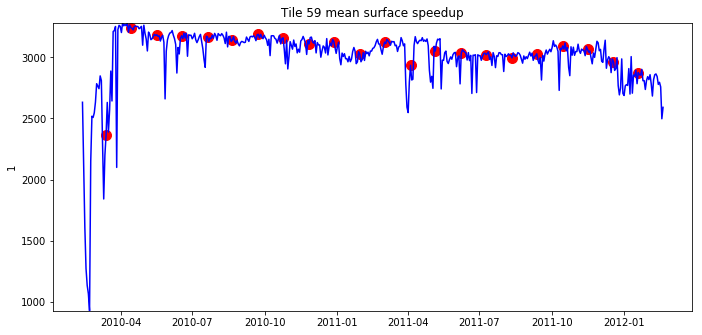

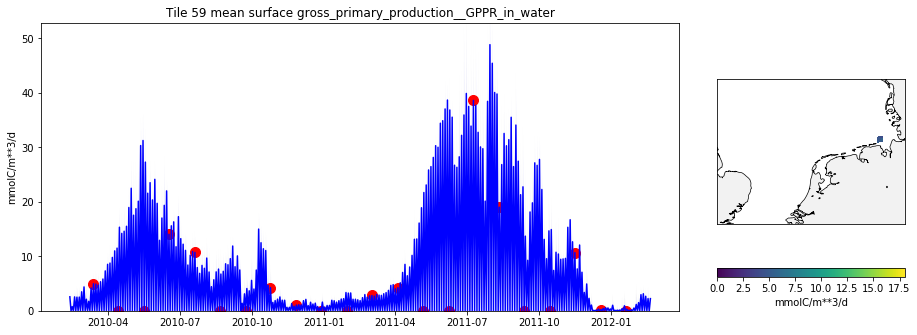

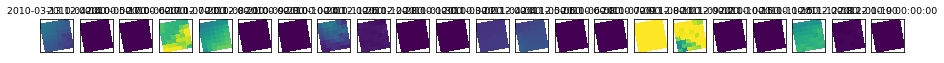

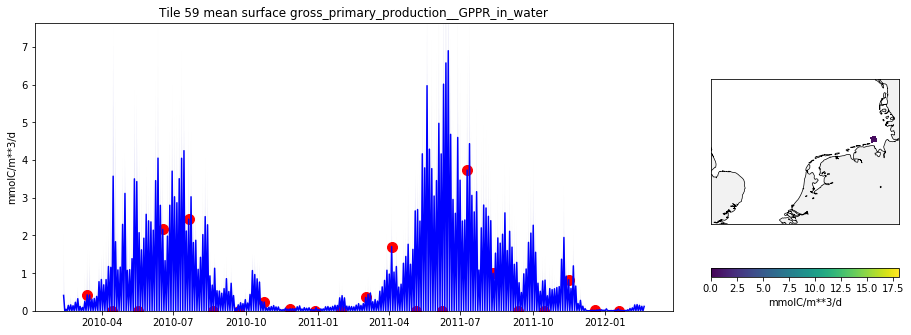

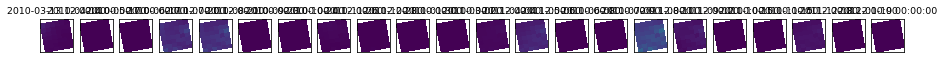

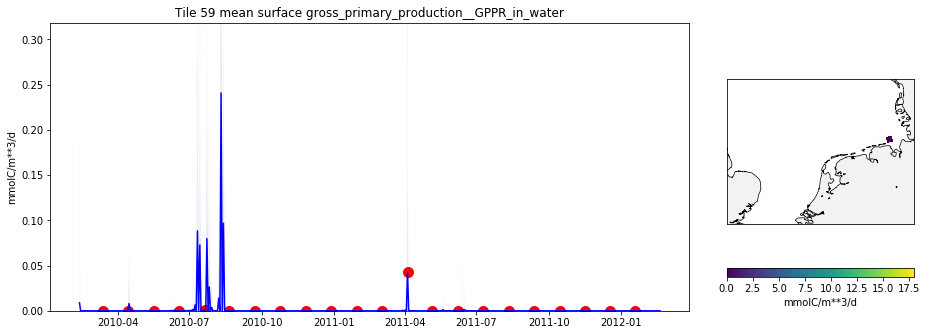

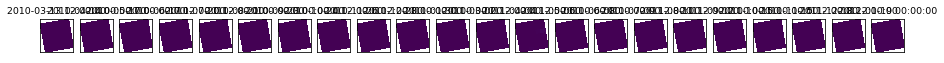

In [64]:
widgetl = widgets.Dropdown(options=['surface','lowest','mean'], value='surface',
                          description='Vertical: ')
widgetn = widgets.IntSlider(min=1, max=24, step=1, value=22, continuous_update=False, description='Snaps: ',)
widgetv = widgets.Dropdown(options=Variables(filename),
                         value='speedup',description='Variable: ')
widgett = widgets.Dropdown(options=list(Tiles(filename)),value=59,description='Tile: ')

widgetf = widgets.Text(value=filename, placeholder='', description='', disabled=True)
ui_elements = widgets.VBox([widgets.HBox([widgetf, widgetl]), 
                            widgets.HBox([widgetv,widgett,widgetn])])

ui = widgets.interactive_output(surfplots,  
    {'varname': widgetv, 'tile': widgett, 'n': widgetn ,'filename': widgetf, 
    'vertical': widgetl})

display(ui_elements, ui)